#  This is to create a volcano plot from a lost of DEGs from bulkRNAseq analysis

import packages

In [120]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
import numpy as np
from adjustText import adjust_text

definde functions to find genes of interest

In [121]:
# define a function to search for gene in the list
def find_genes(row):
    for gene in genes_to_find:
        if gene in row:
            return gene

# define a function to return a variable, if a condition is met (boundries for log2FC and padj)


def map_color(a):
    log2FoldChange, genes, neg_log10_padj = a
    if genes in genes_to_find:
        return 'EBI2-axis'
    elif log2FoldChange > 1 and neg_log10_padj > 1.3:
        return 'upregulated'
    elif log2FoldChange < -1 and neg_log10_padj > 1.3:
        return 'downregulated'
    else:
        return 'not significant'

#input

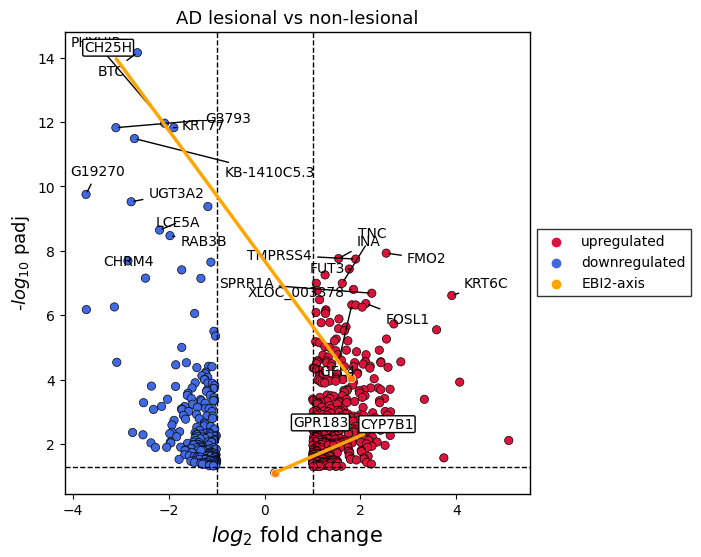

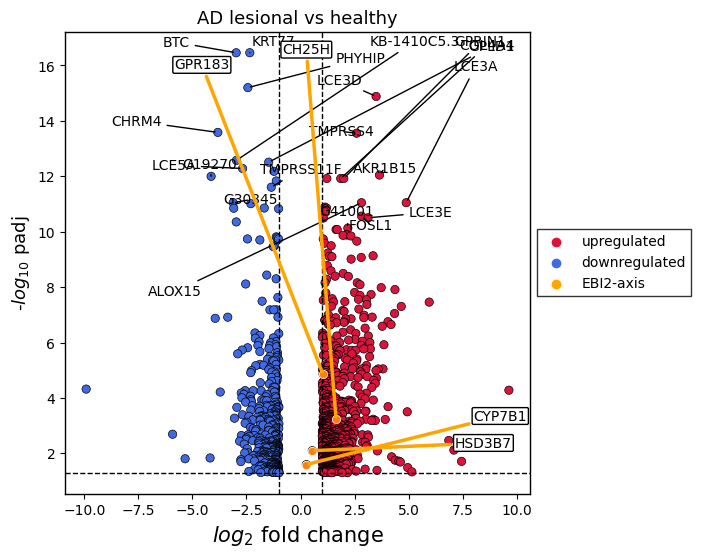

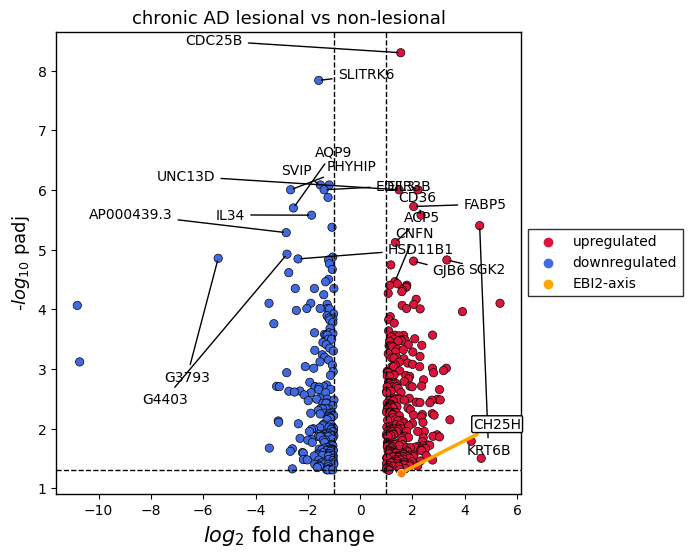

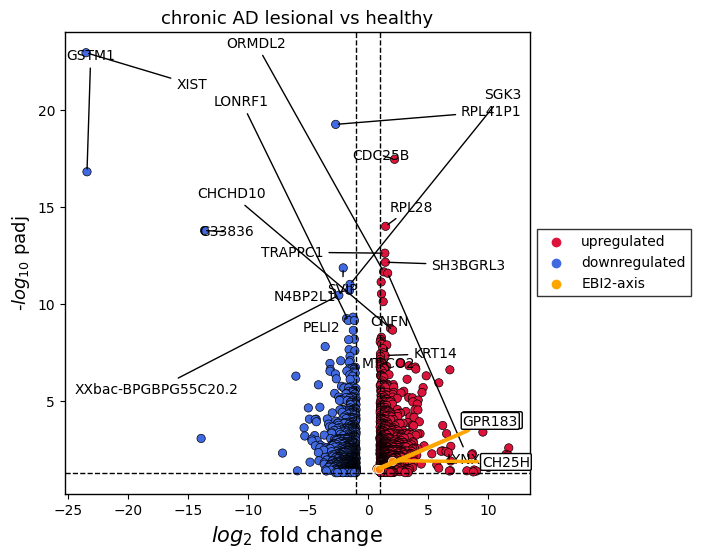

In [122]:
###manually add input
list_of_plot_titles = [#'PSO lesional vs non-lesional',
                    #'PSO lesional vs healthy',
                    'AD lesional vs non-lesional',
                    'AD lesional vs healthy',
                    'chronic AD lesional vs non-lesional',
                    'chronic AD lesional vs healthy']
list_of_comparisons = [#'PSO_L_vs_NL',
                    #'PSO_L-vs_CTRL_H',
                    'AD_L_vs_AD_NL',
                    'AD_L_vs_CTRL_H',
                    'CAD_L_vs_CAD_NL',
                    'CAD_L_vs_CTRL_H']
list_of_filenames = [#'DEGs_PSO_NL_vs_PSO_L', 
                    #'DEGs_CTRL_H_vs_PSO_L',
                    'DEGS_AD_NL_vs_AD_L',
                    'DEGs_CTRL_H_vs_AD_L',
                    'DEGs_CAD_NL_vs_CAD_L',
                    'DEGs_CTRL_H_vs_CAD_L']

#relevant genes
genes_to_find = ['GPR183', 'CH25H', 'CYP7B1', 'HSD3B7']


### read the data, add neg log 10 of adjusted p value and add a column with the color
for comparison, filename, title in zip(list_of_comparisons, list_of_filenames, list_of_plot_titles):
    df = pd.read_csv(f"{filename}.csv", sep=",").dropna()
    df.columns.values[0] = 'genes'
    if 'padj' in df.columns:
        df['neg_log10_padj'] = -np.log10(df['padj'])
    df['color'] = df[['log2FoldChange', 'genes',
                      'neg_log10_padj']].apply(map_color, axis=1)



    ###start plotting
    plt.figure(figsize=(6, 6))

    # Filter the dataframe to only include up or downregulated genes
    df = df[df['color'].isin(['upregulated', 'downregulated', 'EBI2-axis'])]

    # Continue with your plotting code...
    ax = sns.scatterplot(
        data=df,
        x="log2FoldChange",
        y="neg_log10_padj",
        hue='color',
        hue_order=['upregulated', 'downregulated', 'EBI2-axis'],
        palette=['crimson', 'royalblue', 'orange'],
        edgecolor='black',
        zorder=0)
    ax.axhline(1.3, ls='--', lw=1, zorder=2, c='k')
    ax.axvline(1, ls='--', lw=1, zorder=2, c='k')
    ax.axvline(-1, ls='--', lw=1, zorder=2, c='k')

    # Sort the dataframe by -log10 padj for upregulated and downregulated genes separately
    df_padj_sorted_up = df[(df['color'] == 'upregulated') & (
        df['log2FoldChange'] > 1.3)].sort_values(by='neg_log10_padj', ascending=False)
    df_padj_sorted_down = df[(df['color'] == 'downregulated') & (
        df['log2FoldChange'] < -1.3)].sort_values(by='neg_log10_padj', ascending=False)

    # Get the top 10 genes in -log10 padj for both upregulated and downregulated genes
    top_padj_genes_up = df_padj_sorted_up.head(10)['genes'].tolist()
    top_padj_genes_down = df_padj_sorted_down.head(10)['genes'].tolist()

    # Combine the lists
    top_genes = top_padj_genes_up + top_padj_genes_down

    # Annotate these genes
    for i in range(len(df)):
        if df.iloc[i].genes in top_genes:
            x, y = df.iloc[i].log2FoldChange, df.iloc[i].neg_log10_padj
            texts.append(ax.annotate(df.iloc[i].genes, (x, y), textcoords="offset points", xytext=(
                0, 10), ha='center', va='bottom', arrowprops=dict(arrowstyle='-', color='black')))

    for i in range(len(df)):
        for gene in genes_to_find:
            if gene == df.iloc[i].genes:
                x, y = df.iloc[i].log2FoldChange, df.iloc[i].neg_log10_padj
                texts.append(ax.annotate(df.iloc[i].genes, (x, y), textcoords="offset points", xytext=(100, 40), ha='center', va='bottom', color='black', arrowprops=dict(
                    arrowstyle='-', color='orange', lw=2.5), bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1')))

    # plot points for genes_to_find
    genes_to_find_df = df[df['genes'].isin(genes_to_find)]
    sns.scatterplot(data=genes_to_find_df, x="log2FoldChange",
                    y="neg_log10_padj", ax=ax, zorder=2)

    # Adjust text labels
    adjust_text(texts, ax=ax, force_points=0.2, force_text=0.2,
                expand_points=(1, 1), expand_text=(1, 1))

    # axes
    for axis in ['bottom', 'left', 'top', 'right']:
        ax.spines[axis].set_linewidth(1)

    # legend
    legend = ax.legend(loc='center left', bbox_to_anchor=(
        1, 0.5), title=None, edgecolor='black', fancybox=False)
    frame = legend.get_frame()
    frame.set_linewidth(1)

    plt.xticks(size=10)
    plt.yticks(size=10)

    plt.xlabel('$log_{2}$ fold change', size=15)
    plt.ylabel('-$log_{10}$ padj', size=13)
    plt.title(f'{title}', size=13)

    # save the plot
    plt.savefig(f'volcano{filename}.pdf', dpi=300, bbox_inches='tight')

    plt.show()